In [1]:
import os
import sys
py_files_dir = os.path.abspath("../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import instrument_matrices as matrices
import helper_functions as funcs

In [2]:
# Making all plots have a white rather than transparent background
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# Setting Up Polarized Standards Information

In [3]:
# Loading in all data files
csv_directory = '../../data/polarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# List of target names and CSV file paths
targets_info = [
    {"name": "HDE279658", "path": "/home/shared/exoserver/VAMPIRES/20220127/HDE279658/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HDE279658_675_nm_Header_Parameters_R_15_Aperture.csv"},
    {"name": "HD29333", "path": "/home/shared/exoserver/VAMPIRES/20220127/HD29333/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HD29333_675_nm_Header_Parameters_R_15_Aperture.csv"},
    {"name": "HD29835", "path": "/home/shared/exoserver/VAMPIRES/20220127/HD29835/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HD29835_675_nm_Header_Parameters_R_15_Aperture.csv"}
]

# Theoretical target values from Whittet
targets = {
    "HDE279658": {"p_max": (2.81, 0.03), "lam_max": (0.53, 0.01), "k": (0.99, 0.06), 
        "675nm": (2.65, 0.04, 146, 1), "750nm": (2.49, 0.05, 144, 1)},
    "HD29333": {"p_max": (5.25, 0.07), "lam_max": (0.54, 0.02), "k": (0.89, 0.07),
        "675nm": (5.02, 0.1, 71, 1), "750nm": (4.77, 0.13, 71, 1)},
    "HD29835": {"p_max": (4.07, 0.07), "lam_max": (0.5, 0.03), "k": (0.93, 0.11),
        "675nm": (3.72, 0.15, 22, 1), "750nm": (3.49, 0.18, 25, 1)}
}

# Loading Data Files

In [4]:
csv_directory = '../../data/polarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Setting Instrument Parameters

In [5]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0.0176  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Performing Matrix Inversion

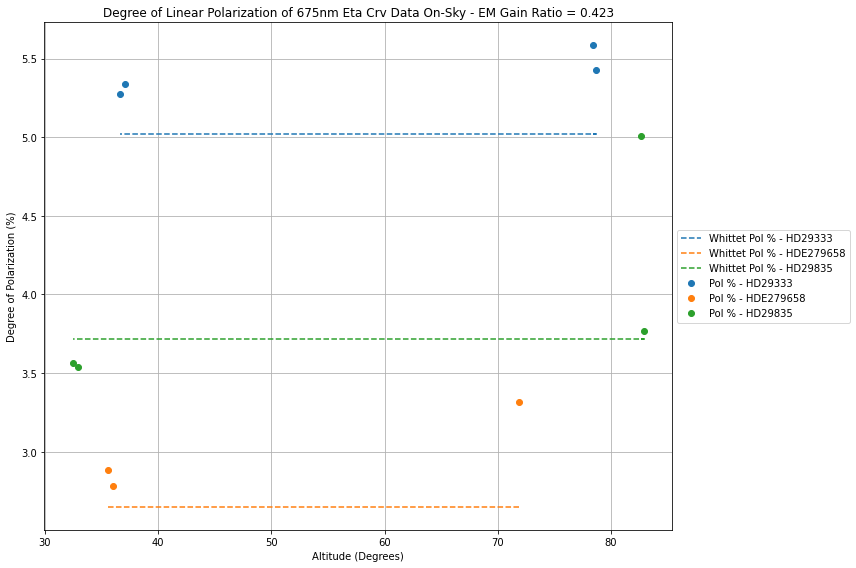

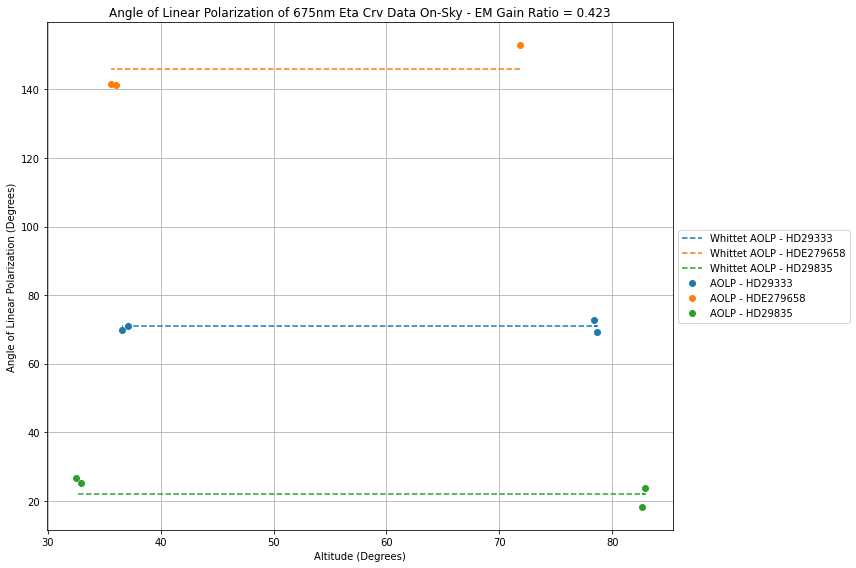

In [6]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
pol_list = []
aolp_list = []
pol_err_list = []
aolp_err_list = []
final_altitudes = []
these_inst_matrices = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        parang = row["PA"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate full instrument matrices for on-sky
            these_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor=double_diff_factor)
            double_diff_matrix = these_inst_matrices[0]
            double_sum_matrix = these_inst_matrices[1]

            # Saving instrument matrices
            inst_matrices.append(double_diff_matrix)
            inst_matrices.append(double_sum_matrix)

            # Normalizing by the flux in the double sum matrix (?)
            first_rows.append(double_diff_matrix[0, : ] / double_sum_matrix[0, 0])

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector on-sky
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape errors to a column vector

            # Setting the I component to be 1
            measurement_matrix[:, 0] = 1
            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix[:,:-1]) @ errors

            # Extract Q and U from s_HWP and their errors
            dHWP = s_HWP[0]
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Calculate degree and angle of linear polarization
            pol_percent, aolp = funcs.stokes_to_deg_pol_and_aolp(Q, U)
            pol_percent_err, aolp_err = \
                funcs.stokes_to_deg_pol_and_aolp_errors(Q, U, Q_err, U_err)
            
            # Append polarization, angle, altitude, and errors to the lists
            pol_list.append((altitude, pol_percent, color, obj))
            aolp_list.append((altitude, aolp, color, obj))
            pol_err_list.append(pol_percent_err)
            aolp_err_list.append(aolp_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
pol_err_list = np.abs(pol_err_list)
aolp_err_list = np.abs(aolp_err_list)

# Plotting Degree of Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, pol_percent, color, obj), pol_err in zip(pol_list, pol_err_list):
    label = f'Pol % - {obj}' if f'Pol % - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, pol_percent, 
                 # yerr=pol_err, 
                 label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Pol % - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_deg_pol = targets[obj]["675nm"][0]
        altitudes = [alt for alt, _, _, o in pol_list if o == obj]
        plt.plot(altitudes, [whittet_deg_pol]*len(altitudes), linestyle='--', color=color, label=f'Whittet Pol % - {obj}')

plt.title(f"Degree of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Degree of Polarization (%)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

# Plotting Angle of Linear Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, aolp, color, obj), aolp_err in zip(aolp_list, aolp_err_list):
    label = f'AOLP - {obj}' if f'AOLP - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, aolp % 180, 
                 # yerr=aolp_err, 
                 label=label, linestyle='None', marker='o', color=color)
    plotted_labels.add(f'AOLP - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_aolp = targets[obj]["675nm"][2] 
        altitudes = [alt for alt, _, _, o in aolp_list if o == obj]
        plt.plot(altitudes, [whittet_aolp]*len(altitudes), linestyle='--', color=color, label=f'Whittet AOLP - {obj}')


plt.title(f"Angle of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Angle of Linear Polarization (Degrees)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()


# Errorbars - Matrix Inversion Method

/home/rebeccaz/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


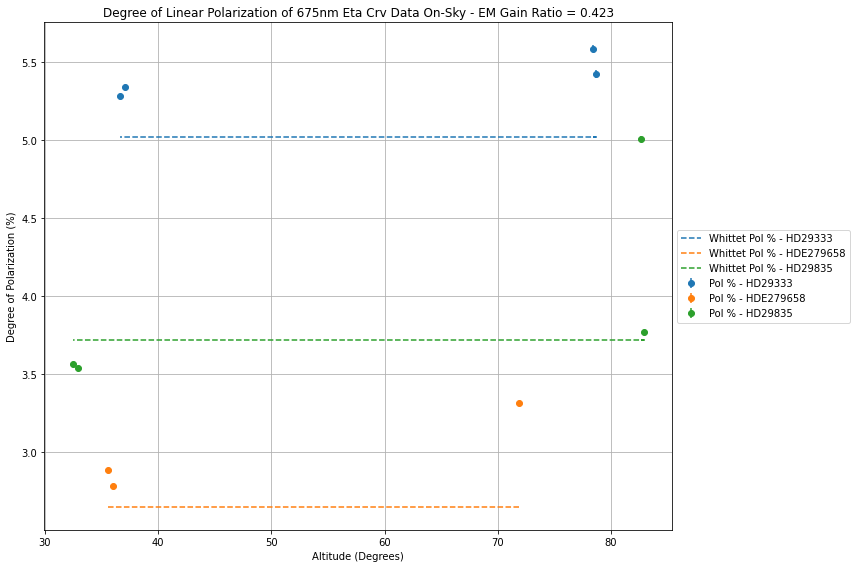

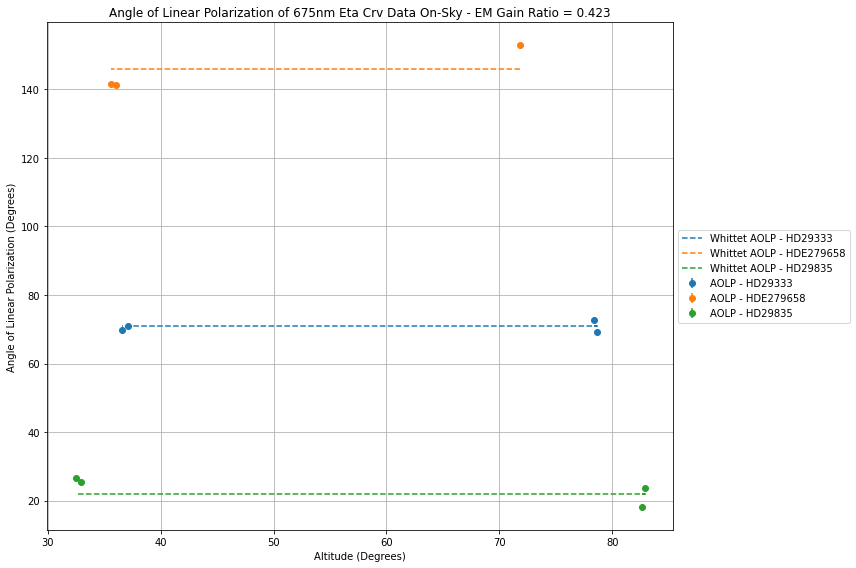

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_data and other necessary data and functions are already loaded

# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
pol_list = []
aolp_list = []
pol_err_list = []
aolp_err_list = []
final_altitudes = []
these_inst_matrices = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        parang = row["PA"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate full instrument matrices for on-sky
            these_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor=double_diff_factor)
            double_diff_matrix = these_inst_matrices[0]
            double_sum_matrix = these_inst_matrices[1]

            # Saving instrument matrices
            inst_matrices.append(double_diff_matrix)
            inst_matrices.append(double_sum_matrix)

            # Normalizing by the flux in the double sum matrix (?)
            first_rows.append(double_diff_matrix[0, : ] / double_sum_matrix[0, 0])

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector on-sky
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Setting the I component to be 1
            measurement_matrix[:, 0] = 1
            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix[:,:-1]) @ errors

            # Extract Q and U from s_HWP and their errors
            dHWP = s_HWP[0]
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Calculate degree and angle of linear polarization
            pol_percent, aolp = funcs.stokes_to_deg_pol_and_aolp(Q, U)
            pol_percent_err, aolp_err = \
                funcs.stokes_to_deg_pol_and_aolp_errors(Q, U, Q_err, U_err)

            # Append polarization, angle, altitude, and errors to the lists
            pol_list.append((altitude, pol_percent, color, obj))
            aolp_list.append((altitude, aolp, color, obj))
            pol_err_list.append(pol_percent_err)
            aolp_err_list.append(aolp_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
pol_err_list = np.abs(pol_err_list)
aolp_err_list = np.abs(aolp_err_list)

# Plotting Degree of Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, pol_percent, color, obj), pol_err in zip(pol_list, pol_err_list):
    label = f'Pol % - {obj}' if f'Pol % - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, pol_percent, yerr=pol_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Pol % - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_deg_pol = targets[obj]["675nm"][0]
        altitudes = [alt for alt, _, _, o in pol_list if o == obj]
        plt.plot(altitudes, [whittet_deg_pol]*len(altitudes), linestyle='--', color=color, label=f'Whittet Pol % - {obj}')

plt.title(f"Degree of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Degree of Polarization (%)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

# Plotting Angle of Linear Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, aolp, color, obj), aolp_err in zip(aolp_list, aolp_err_list):
    label = f'AOLP - {obj}' if f'AOLP - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, aolp % 180, yerr=aolp_err, label=label, linestyle='None', marker='o', color=color)
    plotted_labels.add(f'AOLP - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_aolp = targets[obj]["675nm"][2] 
        altitudes = [alt for alt, _, _, o in aolp_list if o == obj]
        plt.plot(altitudes, [whittet_aolp]*len(altitudes), linestyle='--', color=color, label=f'Whittet AOLP - {obj}')

plt.title(f"Angle of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Angle of Linear Polarization (Degrees)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()


# Values + Errorbars - Bootstrapping

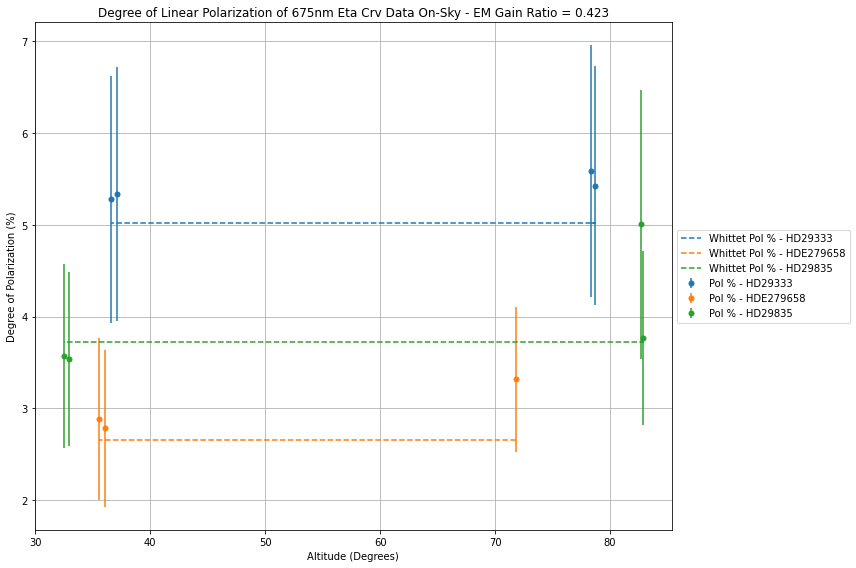

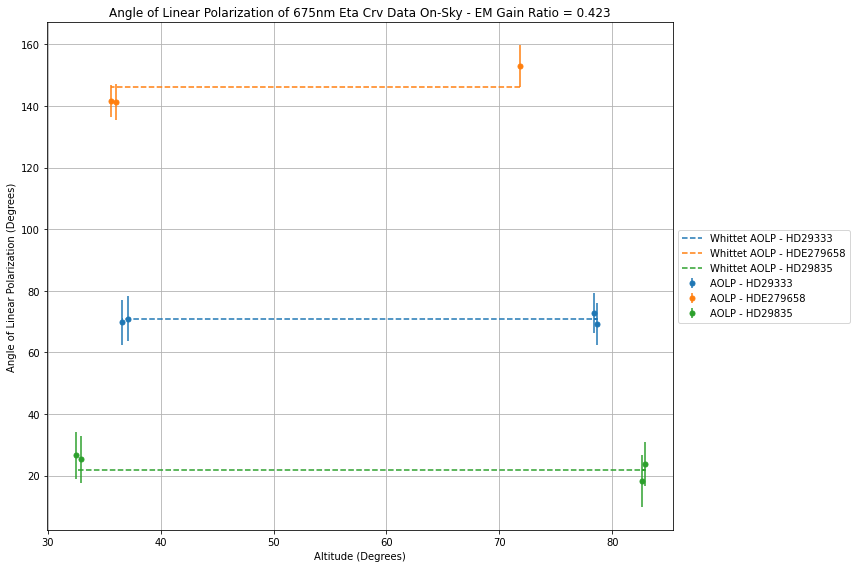

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_data and other necessary data and functions are already loaded

# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
pol_list = []
aolp_list = []
pol_err_list = []
aolp_err_list = []
final_altitudes = []
these_inst_matrices = []

model = matrices.full_system_mueller_matrix

# Parameters for bootstrapping
num_bootstrap_samples = 1000

def bootstrap_errors(measurement_matrix, measurements, num_bootstrap_samples):
    bootstrap_samples = np.zeros((num_bootstrap_samples, 3))  # For dHWP, Q, U
    
    for i in range(num_bootstrap_samples):
        indices = np.random.choice(range(measurements.shape[0]), size=measurements.shape[0], replace=True)
        bootstrap_measurements = measurements[indices]
        bootstrap_matrix = measurement_matrix[indices]
        
        # Compute the Stokes parameters for the bootstrapped dataset
        s_HWP_bootstrap = np.linalg.pinv(bootstrap_matrix[:, :-1]) @ bootstrap_measurements
        bootstrap_samples[i] = s_HWP_bootstrap.flatten()
    
    s_HWP_std = bootstrap_samples.std(axis=0)
    
    return s_HWP_std

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        parang = row["PA"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate full instrument matrices for on-sky
            these_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor=double_diff_factor)
            double_diff_matrix = these_inst_matrices[0]
            double_sum_matrix = these_inst_matrices[1]

            # Saving instrument matrices
            inst_matrices.append(double_diff_matrix)
            inst_matrices.append(double_sum_matrix)

            # Normalizing by the flux in the double sum matrix (?)
            first_rows.append(double_diff_matrix[0, : ] / double_sum_matrix[0, 0])

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector on-sky
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Setting the I component to be 1
            measurement_matrix[:, 0] = 1

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

            # Extract Q and U from s_HWP
            dHWP = s_HWP[0]
            Q = s_HWP[1]
            U = s_HWP[2]

            # Bootstrap to estimate errors
            s_HWP_std = bootstrap_errors(measurement_matrix, measurements, num_bootstrap_samples)

            # Extract Q and U errors from s_HWP_std
            Q_err = s_HWP_std[1]
            U_err = s_HWP_std[2]

            # Calculate degree and angle of linear polarization
            pol_percent, aolp = funcs.stokes_to_deg_pol_and_aolp(Q, U)
            pol_percent_err, aolp_err = funcs.stokes_to_deg_pol_and_aolp_errors(Q, U, Q_err, U_err)

            # Append polarization, angle, altitude, and errors to the lists
            pol_list.append((altitude, pol_percent, color, obj))
            aolp_list.append((altitude, aolp, color, obj))
            pol_err_list.append(pol_percent_err)
            aolp_err_list.append(aolp_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
pol_err_list = np.abs(pol_err_list)
aolp_err_list = np.abs(aolp_err_list)

# Plotting Degree of Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, pol_percent, color, obj), pol_err in zip(pol_list, pol_err_list):
    label = f'Pol % - {obj}' if f'Pol % - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, pol_percent, yerr=pol_err, label=label, linestyle='None', marker='o', markersize=5, color=color, markerfacecolor=color)
    plotted_labels.add(f'Pol % - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_deg_pol = targets[obj]["675nm"][0]
        altitudes = [alt for alt, _, _, o in pol_list if o == obj]
        plt.plot(altitudes, [whittet_deg_pol]*len(altitudes), linestyle='--', color=color, label=f'Whittet Pol % - {obj}')

plt.title(f"Degree of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Degree of Polarization (%)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

# Plotting Angle of Linear Polarization
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, aolp, color, obj), aolp_err in zip(aolp_list, aolp_err_list):
    label = f'AOLP - {obj}' if f'AOLP - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, aolp % 180, yerr=aolp_err, label=label, linestyle='None', marker='o', markersize=5, color=color)
    plotted_labels.add(f'AOLP - {obj}')

# Plot theoretical values
colors = itertools.cycle(plt.cm.tab10.colors)  # Reset color cycle
for obj in unique_objects:
    if obj in targets:
        color = next(colors)  # Ensure matching color
        whittet_aolp = targets[obj]["675nm"][2] 
        altitudes = [alt for alt, _, _, o in aolp_list if o == obj]
        plt.plot(altitudes, [whittet_aolp]*len(altitudes), linestyle='--', color=color, label=f'Whittet AOLP - {obj}')


plt.title(f"Angle of Linear Polarization of {wavelength}nm Eta Crv Data On-Sky - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Angle of Linear Polarization (Degrees)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()


# Printing Double Diff Matrices

In [9]:
print(inst_matrices[7])
print(inst_matrices[8])

[[ 1.41833777  0.16959429  0.06120506 -0.26774036]
 [-0.56470095 -0.33380715 -0.09188553  0.74909366]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.01559631 -0.10656628 -1.13531854 -0.16461498]
 [-0.00632401  0.04321064  0.46035053  0.06674831]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


# Printing Double Sum Matrices

In [10]:
print(inst_matrices[1 :: 2])

[array([[ 1.41612551e+00, -1.31855364e-03,  2.66970856e-02,
        -3.11782203e-01],
       [-5.61117778e-01,  6.33627000e-02, -1.10256815e-01,
         8.12899799e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]), array([[ 1.41818278,  0.02734146,  0.14748697, -0.28505017],
       [-0.56451923, -0.07559777, -0.2574758 ,  0.78025475],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]]), array([[ 1.41621032, -0.0463916 ,  0.06403427, -0.30316706],
       [-0.56157196,  0.06353058, -0.1518137 ,  0.80647619],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]]), array([[ 1.41833777,  0.16959429,  0.06120506, -0.26774036],
       [-0.56470095, -0.33380715, -0.09188553,  0.74909366],
       [ 0.        ,  0.        ,  0.      